# Problem 3 Naive Bayes

## 3.1 implement a Naive Bayes classifier

In [4]:
import sys
import itertools
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import time
from copy import deepcopy

In [5]:
class Model:
    def __init__(self, wordlist):
        self.wordlist = wordlist

    def count_labels(self, data):
        """
        Count the number of positive labels and negative labels.
        Returns (a tuple or a numpy array of two elements):
            * negative_count: a non-negative integer, which represents the number of negative labels (non-spam emails);
            * positive_count: a non-negative integer, which represents the number of positive labels (spam emails).
        """
        # TODO
        count1=0
        count0=0
        for i in data:
            if i[0]==1:
                count1+=1
            else:
                count0+=1
        return (count0,count1)   
    

    def count_words(self, wordlist, data):
        """
        Count the number of times that each word appears in emails under a given label.
        Returns (a numpy array):
            * word_counts: a numpy array with shape (2, L), where L is the length of $wordlist,
                - word_counts[0, i] represents the number of times that word $wordlist[i] appears in non-spam (negative) emails, and
                - word_counts[1, i] represents the number of times that word $wordlist[i] appears in spam (positive) emails.
        """
        # TODO
        arr = np.zeros((2,len(wordlist)))
        for i in range(len(wordlist)):
            w = wordlist[i]
            count0 = 0
            count1 = 0
            for j in data:
                if w in j[1]:
                    if j[0]==0:
                        count0+=1
                    else:
                        count1+=1
            arr[0,i]=count0
            arr[1,i]=count1               
        return arr

    def calculate_probability(self, label_counts, word_counts):
        """
        Calculate the probabilities, both the prior and likelihood.
        Returns (a pair of numpy array):
            * prior_probs: a numpy array with shape (2, ), only two elements, where
                - prior_probs[0] is the prior probability of negative labels, and
                - prior_probs[1] is the prior probability of positive labels.
            * likelihood_probs: a numpy array with shape (2, L), where L is the length of the word list,
                - likelihood_probs[0, i] represents the likelihood probability of the $i-th word in the word list, given that the email is non-spam (negative), and
                - likelihood_probs[1, i] represents the likelihood probability of the $i-th word in the word list, given that the email is spam (positive).
        """
        # TODO
        prior_probs = np.zeros((2,))
        prior_probs[0] = label_counts[0]/(label_counts[0]+label_counts[1])
        prior_probs[1] = label_counts[1]/(label_counts[0]+label_counts[1])
        
        L = len(self.wordlist)
        likelihood_probs = np.zeros((2,L))
        for i in range(L):
            likelihood_probs[0,i] = word_counts[0,i]/label_counts[0]
            likelihood_probs[1,i] = word_counts[1,i]/label_counts[1]
        return prior_probs, likelihood_probs
    

    def fit(self, data):
        label_counts = self.count_labels(data)
        word_counts = self.count_words(self.wordlist, data)

        self.prior_probs, self.likelihood_probs = self.calculate_probability(label_counts, word_counts)

        # TO AVOID NUMBER OVERFLOW here we use log probability instead.
        self.log_prior_probs = np.log(self.prior_probs)
#??????????????
        self.log_likelihood_probs = np.dstack([np.log(1 - self.likelihood_probs), np.log(self.likelihood_probs)])

    def predict(self, x):
        """
        Predict whether email $x is a spam or not.
        Returns:
            * y: a boolean value indicating whether $x is a spam or not.
        """ 
        p0 = 1
        p1 = 1
        for w in x:
            if w in self.wordlist:
                index = self.wordlist.index(w)
                if self.log_likelihood_probs[0][index][0]!=0:
                    p0+=self.log_likelihood_probs[0][index][1]
                if self.log_likelihood_probs[1][index][0]!=0:
                    p1+=self.log_likelihood_probs[1][index][1]
        p0+= self.log_prior_probs[0]
        p1+= self.log_prior_probs[1]
        if p1>=p0:
            return 1
        else:
            return 0
                    

In [6]:
def read_data(filename):
    """
    Read the dataset from the file given by name $filename.
    The returned object should be a list of pairs of data. In each pair: the first element is 1 (for spam emails) 
    or 0 (for non-spam emails), the second element is a list of words in the email.
    The returned list: 
        [
            (1 , ['a', 'b', 'c']),
            (0, ['d', 'e', 'f']),
            ...
        ]
    """
    file = open(filename,"r")
    line = file.readline()
    lists = []
    while len(line)!=0:
        lst = line.rstrip("\n").split(" ")
        label = int(lst[0])
        arr = lst[1:]
        temp = (label,arr)
        lists.append(temp)
        line = file.readline()
    return lists

def split_train(original_train_data, size=4000):
    return original_train_data[:size], original_train_data[size:]


def create_wordlist(original_train_data, threshold=26):
    """
    Create a word list from the original training set.
    Only get a word if it appears in at least $threshold emails.
    Returns:
        * a python list containing all the words that occur in at least $threshold emails.
    """
    dic = {}   
    #dic = {'a':(2,True),'b':(1,False)...} 
    #if True, the word has not appeared in the text, if false, the word has been marked, so we skip it
    for i in range(len(original_train_data)):
        for j in range(len(original_train_data[i][1])):
            if original_train_data[i][1][j] in dic:
                if dic[original_train_data[i][1][j]][1]==True:
                    temp = (dic[original_train_data[i][1][j]][0]+1,False)
                    dic[original_train_data[i][1][j]] = temp
            else:
                dic[original_train_data[i][1][j]] = (1,False)
        for w in dic.keys():   #initialize the markers
            temp = (dic[w][0],True)
            dic[w] = temp
    arr = []
    for w in dic.keys(): 
        if dic[w][0]>=threshold:
            arr.append(w)        
    return arr

In [7]:
# threshold to determine whether to include a word in the dictionary/wordlist.
# ie. only words with frequency higher than threshold are included
THRESHOLD = 26

In [77]:
original_train_data = read_data('spam_train.txt')


# further split the data into a training set and a validation set
train_data, val_data = split_train(original_train_data)


# Create the word list.
wordlist = create_wordlist(original_train_data, 26)
print("Total # of words:", len(wordlist))

# fit the model using train_data
model = Model(wordlist)
model.fit(original_train_data)


# TODO
# calculate the error rate on val_data (when threshold=26)
# print out the error rate


error_count = sum([y != model.predict(x) for y, x in val_data])
error_percentage = 100.0 * error_count / len(val_data)
print("Validation error, # = {:>4d}, % = {:>8.4f}%.".format(error_count, error_percentage))

Total # of words: 3048


<ipython-input-74-39dab0b1a316>:80: RuntimeWarning: divide by zero encountered in log
  self.log_likelihood_probs = np.dstack([np.log(1 - self.likelihood_probs), np.log(self.likelihood_probs)])


Validation error, # =  131, % =  13.1000%.


## 3.2 try different thresholds, find the optimal threshold (which gives minimum validation error), print out the test error at the optimal threshold

In [78]:
def compute_error_rate(model, data):    
    error_count = sum([y != model.predict(x) for y, x in data])
    return 100.0 * error_count / len(data)

In [9]:
thresholds = list(range(1, 35))
train_error = []
val_error = []
test_error = []
original_train_data = read_data('spam_train.txt')
train_data, val_data = split_train(original_train_data)
test_data = read_data('spam_test.txt')

In [80]:
for th in thresholds:
    print('With threshold {}....'.format(th))
    time1 = time.time()

    # vocabulary selection
    wordlist = create_wordlist(original_train_data, th)

    # fit model using the wordlist
    model = Model(wordlist)
    model.fit(train_data)

    # compute classification error rates
    err_train = compute_error_rate(model, train_data)
    err_val = compute_error_rate(model, val_data)
    err_test = compute_error_rate(model, test_data)

    # store results for plotting
    train_error.append(err_train)
    val_error.append(err_val)
    test_error.append(err_test)

    time2 = time.time()
    print("train:{} val:{} test:{} len(V)={}".format(err_train, err_val, err_test, len(wordlist)))
    print('time: {}'.format(time2 - time1))

With threshold 1....


<ipython-input-74-39dab0b1a316>:80: RuntimeWarning: divide by zero encountered in log
  self.log_likelihood_probs = np.dstack([np.log(1 - self.likelihood_probs), np.log(self.likelihood_probs)])


train:64.075 val:57.3 test:58.1 len(V)=65812
time: 2032.6159002780914
With threshold 2....
train:57.4 val:57.3 test:53.5 len(V)=19298
time: 814.350567817688
With threshold 3....
train:51.9 val:54.0 test:49.3 len(V)=12882
time: 476.2333481311798
With threshold 4....
train:47.425 val:49.7 test:45.3 len(V)=10362
time: 406.3313248157501
With threshold 5....
train:43.1 val:46.2 test:40.7 len(V)=8773
time: 382.0371460914612
With threshold 6....
train:38.775 val:41.8 test:37.3 len(V)=7803
time: 324.1410689353943
With threshold 7....
train:35.225 val:38.1 test:35.2 len(V)=7085
time: 335.27117896080017
With threshold 8....
train:32.3 val:35.4 test:32.8 len(V)=6493
time: 472.5269150733948
With threshold 9....
train:29.9 val:32.8 test:30.8 len(V)=5982
time: 266.7581880092621
With threshold 10....
train:28.325 val:31.0 test:29.0 len(V)=5603
time: 310.2769601345062
With threshold 11....
train:27.125 val:29.7 test:27.4 len(V)=5303
time: 262.27193117141724
With threshold 12....
train:25.45 val:28.5 t

ValueError: x and y must have same first dimension, but have shapes (34,) and (0,)

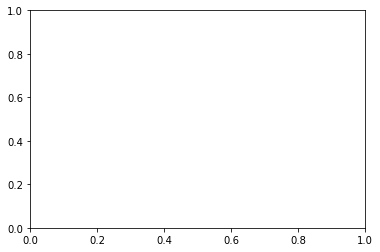

In [10]:
# plot the training and validation error rate vs. the thresholds
# choose the threshold with the minimal validation error rate and report the corresponding test error rate

# TODO

plt.plot(thresholds,train_error, label = 'training error')
plt.plot(thresholds,val_error, label = 'validation error')
plt.legend()
opt=val_error.index(min(val_error))
print('Best performance at validated threshold {} with test error rate {}.'.format(opt+1, val_error[opt]/len(val_data)))